# Psi4 FCI Example

This notebook requires installing [Psi4](https://psicode.org/). We will run a CAP/FCI calculation on H2 to obtain the resonance position and width of the doubly excited \\({}^1 \Sigma^+_g \\) state.

In [9]:
import psi4
import numpy as np
import pyopencap
import time

In [10]:
psi4.core.set_output_file('output.dat', False)

# Step 1: Define basis set and geometry

In [11]:
mol = psi4.geometry("""
    @He 0.0000000000 0.0000000000 -0.7400000000
    @He 0.0000000000 0.0000000000 0.7400000000
    H 0.0000000000 0.0000000000 0.3705000000
    H 0.0000000000 0.0000000000 -0.3705000000""")
def basisspec_psi4_yo__anonymous03952cbd(mol, role):
    basstrings = {}
    mol.set_basis_all_atoms("test_bas", role=role)
    basstrings['test_bas'] = """
        spherical
        ****
        H    0
        S   3  1.00
        82.6400000000          0.00200600
        12.4100000000          0.01534300
        2.8240000000           0.07557900
        S   1  1.00
        0.7977000000           1.00000000
        S   1  1.00
        0.2581000000           1.00000000
        S   1  1.00
        0.0898900000           1.00000000
        S   1  1.00
        0.0236300000           1.00000000
        P   1  1.00
        2.2920000000           1.00000000
        P   1  1.00
        0.8380000000           1.00000000
        P   1  1.00
        0.2920000000           1.00000000
        P   1  1.00
        0.0848000000           1.00000000
        D   1  1.00
        2.0620000000           1.00000000
        D   1  1.00
        0.6620000000           1.00000000
        D   1  1.00
        0.1900000000           1.00000000
        F   1  1.00
        1.3970000000           1.00000000
        F   1  1.00
        0.3600000000           1.00000000
        ****
He 0
S 1  1.00
0.0118150000 1.00000000
S 1  1.00
0.0059075000 1.00000000
S 1  1.00
0.0029537500 1.00000000
S 1  1.00
0.0014768750 1.00000000
P 1  1.00
0.0424000000 1.00000000
P 1  1.00
0.0212000000 1.00000000
P 1  1.00
0.0106000000 1.00000000
P 1  1.00
0.0053000000 1.00000000
****
        """
    return basstrings

# Step 2: Run FCI

In [12]:
nstates = 15
psi4.qcdb.libmintsbasisset.basishorde['ANONYMOUS03952CBD'] = basisspec_psi4_yo__anonymous03952cbd
psi4.core.set_global_option("BASIS", "anonymous03952cbd")
E, wfn = psi4.energy('scf', return_wfn=True)
mints = psi4.core.MintsHelper(wfn.basisset())
S_mat = np.asarray(mints.ao_overlap())
n_bas = S_mat.shape[0]
so2ao = mints.petite_list().sotoao()
psi4.molden(wfn, 'h2.molden')
# add 7F to molden file, psi4 doesn't write it for some reason
with open("h2.molden", "a") as myfile:
    myfile.write("\n [7F] \n")
psi4.set_options({"opdm":True,"num_roots":nstates,"tdm":True,"dipmom":True})
ci_energy, ci_wfn = psi4.energy('FCI', return_wfn=True)
h0 = np.zeros((nstates,nstates))
for i in range(0,nstates):
    var_str = 'CI ROOT ' + str(i) + ' TOTAL ENERGY'
    h0[i][i] = float(psi4.get_variable(var_str))

<ipython-input-12-82af8d66fffa>:18: FutureWarning: Using `psi4.core.get_variable` instead of `psi4.core.variable` (or `psi4.core.scalar_variable` for scalar variables only) is deprecated, and in 1.4 it will stop working

  h0[i][i] = float(psi4.get_variable(var_str))


# Step 3: Construct pyopencap objects using molden file

In [13]:
molden_dict = {"basis_file":"h2.molden",
    "molecule": "molden"}
s = pyopencap.System(molden_dict)
s.check_overlap_mat(S_mat,"psi4")
cap_dict = {
    "cap_type": "box",
        "cap_x":"6.00",
            "cap_y":"6.00",
            "cap_z":"6.7",
}
pc = pyopencap.CAP(s,cap_dict,nstates)

Verified overlap matrix.


# Step 4: Pass density matrics in RAM and compute CAP matrix

In [14]:
for i in range(0,nstates):
    for j in range(i,nstates):
        opdm_mo = ci_wfn.get_opdm(i, j, "SUM", True)
        opdm_so = psi4.core.triplet(ci_wfn.Ca(), opdm_mo, ci_wfn.Ca(), False, False, True)
        opdm_ao = psi4.core.Matrix(n_bas,n_bas)
        opdm_ao.remove_symmetry(opdm_so,so2ao)
        pc.add_tdm(opdm_ao.to_array(),i,j,"psi4")
        if not i==j:
            pc.add_tdm(opdm_ao.to_array().conj().T,j,i,"psi4")
pc.compute_projected_cap()
W = pc.get_projected_cap()

Integration time:3.676596


# Step 5: Eigenvalue trajectory

Uncorrected:
(13.235650214294145-0.15159174735555866j)
0.011000000000000001
Corrected:
(13.229142026497271-0.05823329409013468j)
0.031000000000000003


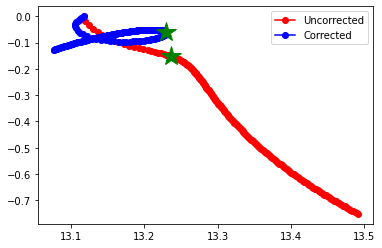

In [15]:
from pyopencap.analysis import CAPHamiltonian
CAPH = CAPHamiltonian(H0=h0,W=W)
eta_list = np.linspace(0,10000,201) * 1E-5
CAPH.run_trajectory(eta_list)
import matplotlib.pyplot as plt
ref_energy = h0[0][0]
traj = CAPH.track_state(1,tracking="overlap")
uc_energies = traj.energies_ev(ref_energy=ref_energy)
corr_energies = traj.energies_ev(ref_energy=ref_energy,corrected=True)
uc_energy, eta_opt = traj.find_eta_opt(start_idx=10)
uc_energy = (uc_energy-ref_energy)*27.2114
corr_energy, corr_eta_opt = traj.find_eta_opt(corrected=True,start_idx=10)
corr_energy = (corr_energy-ref_energy)*27.2114
print("Uncorrected:")
print(uc_energy)
print(eta_opt)
print("Corrected:")
print(corr_energy)
print(corr_eta_opt)
plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
plt.plot(np.real(corr_energies),np.imag(corr_energies),'-bo',label="Corrected")
plt.plot(np.real(uc_energy),np.imag(uc_energy),'g*',markersize=20)
plt.plot(np.real(corr_energy),np.imag(corr_energy),'g*',markersize=20)
plt.legend()
plt.show()

# Optional: Export

For more expensive calculations, it is not always feasible to analyze the trajectories in the same script used to perform the calculation. In this case, the zeroth order Hamiltonian and CAP matrix can be exported using the export function of the CAPHamiltonian object. This file can be used to construct a CAPHamiltonian object in a subsequent script.

In [16]:
# export
CAPH.export("h2_opencap.out")
# import from output file
new_CAPH = CAPHamiltonian(output="h2_opencap.out")